# Additional Figures

In [1]:
# import packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, geopandas as gpd, datetime, glob, math, openpyxl
import matplotlib.pyplot as plt, matplotlib.dates as mdates
from statistics import mean
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import TweedieRegressor
import seaborn as sns; sns.set_theme(color_codes=True)

plt.rcParams['figure.dpi'] = 300

In [2]:
#import data and adjust formatting
path = 'C:/Users/joshb/Desktop/MSc Project/Data/'

df = pd.read_csv(path + 'imd_hesitancy_age_ethnicity__region_df.csv')
df = df.rename(columns={'Unnamed: 0': 'LTLA Names'})
imd_hesitancy_age_ethnicity__region_df = df.set_index('LTLA Names')
imd_hesitancy_age_ethnicity__region_df.head(2)

,region name,IMD: Overall - extent (%),IMD: Barriers to Housing and Services,IMD: Crime,IMD: Education Skills and Training Deprivation,IMD: Employment,IMD: Health Deprivation and Disability,IMD: Income Deprivation,IMD: Living Environment Deprivation,mean age,median age,white british,multiple ethnic group,Black British,Other Ethnic Group,Asian British,hesitancy measure
LTLA Names,,,,,,,,,,,,,,,,,
Adur,South East,7.9,0.00,0.0,7.14,0.00,0.00,0.0,0.00,43.0,44,0.869350,0.013157,0.004648,0.003891,0.015711,0.690059
Allerdale,North West,19.9,13.33,0.0,18.33,13.33,11.67,10.0,21.67,43.1,45,0.950848,0.004247,0.000728,0.000608,0.004756,0.721900


In [3]:
#import data and adjust formatting
df1 = pd.read_csv(path + 'weekly_vac1_prop_data.csv')
weekly_vac1_prop_data_df = df1.set_index('date published')
weekly_vac1_prop_data_df.head(2)

,18-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,...,Under 25,Under 30,Under 40,Under 45,Under 50,Under 55,Under 60,Under 65,Under 70,Under 80
date published,,,,,,,,,,,,,,,,,,,,,
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006135
2021-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010275


In [4]:
# 'full' data from 04/03/21 to 19/08/2021

all_weekly_data = []
all_weekly_dates = []
all_weekly_pop_data = []

for i,f in enumerate(glob.glob("C:/Users/joshb/Desktop/MSc Project/Data/PHE/Weekly/Full data/*.xlsx")):
    if i%2==0:
        print(i+10, end=' ')
    
    all_weekly_dates.append(list(pd.read_excel(f, engine='openpyxl', sheet_name='LTLA',
                                      index_col=None, usecols = "C", header = 6, nrows=0).columns)[0])
    
    all_weekly_data.append(pd.read_excel(f, engine='openpyxl', sheet_name='LTLA',header=[10,11]))
    
    all_weekly_pop_data.append(pd.read_excel(f, engine='openpyxl', sheet_name='Population estimates (NIMS)',
                                             header=[11,12]))

10 12 14 16 18 20 22 24 26 28 30 32 34 

### get the data df in the format we want

In [5]:
all_weekly_data1 = []

for df in all_weekly_data:
    
    # remove multi-index
    df.columns = df.columns.to_flat_index()
    
    # all lower case column names
    df.columns = df.columns.to_series().astype(str).str.lower()
    
    # only columns whose names contains '1st', 'at least 1', 'region name' or 'ltla name'
    df_1st = df.filter(like='1st', axis=1)
    df_at_least_1 = df.filter(like='at least 1', axis=1)
    df_region = df.filter(like='region name', axis=1)
    df_ltla = df.filter(like='ltla name', axis=1)
    df1 = pd.concat([df_region,df_ltla,df_at_least_1,df_1st], axis=1)
    
    # remove any columns that contain '.1'
    df1 = df1[df1.columns[~df1.columns.str.contains('\.1')]]
    
    # add the weekly dataframes all in a big list
    all_weekly_data1.append(df1)

In [6]:
# shorten column names to something more simple
all_weekly_data2 = []
col_names = ['region name', 'ltla name', 'under 18', 'under 25', 'under 30', 'under 35', 'under 40', 'under 45',
             'under 50', 'under 55', 'under 60', 'under 65', 'under 70', 'under 75', 'under 80', '18-24', '25-29', 
             '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']

for df in all_weekly_data1:
    df1 = df.copy()
    for col in col_names:
        df2 = df1.rename(columns=lambda c: col if col in c else c)
        df1 = df2
    all_weekly_data2.append(df1)

In [7]:
# remove any columns with 'unnamed' in the title
all_weekly_data3 = []

for df in all_weekly_data2:
    df1 = df[df.columns[~df.columns.str.contains('unnamed')]]
    all_weekly_data3.append(df1)

In [8]:
# set the index as 'ltla name'
all_weekly_data4 = []

for df in all_weekly_data3:
    df1 = df.set_index('ltla name')
    all_weekly_data4.append(df1)

In [9]:
# remove any rows with an index of nan
all_weekly_data5 = []

for df in all_weekly_data4:
    df1 = df.loc[df.index.dropna()]
    all_weekly_data5.append(df1)

### get the population df in the format we want

In [10]:
all_weekly_pop_data1 = []

for df in all_weekly_pop_data:
    
    # remove multi index
    df.columns = df.columns.to_flat_index()
    
    # change all column names to lowercase
    df.columns = df.columns.to_series().astype(str).str.lower()
    
    # get only columns whose names contain 'population estimates', 'region name' or 'ltla name'
    df_1st = df.filter(like='population estimates', axis=1)
    df_region = df.filter(like='region name', axis=1)
    df_ltla = df.filter(like='ltla name', axis=1)
    df1 = pd.concat([df_region,df_ltla,df_at_least_1,df_1st], axis=1)
    
    # remove any columns whose names include '18+', '16+' or '.'
    df1 = df1[df1.columns[~df1.columns.str.contains('18+')]]
    df1 = df1[df1.columns[~df1.columns.str.contains('16+')]]
    df1 = df1[df1.columns[~df1.columns.str.contains('\.')]]
    
    # add the weekly dataframes all in a big list
    all_weekly_pop_data1.append(df1)

In [11]:
# shorten column names to something more simple
all_weekly_pop_data2 = []
col_names = ['region name', 'ltla name', 'under 18', 'under 25', 'under 30', 'under 35', 'under 40', 'under 45',
             'under 50', 'under 55', 'under 60', 'under 65', 'under 70', 'under 75', 'under 80', '18-24', '25-29', 
             '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']

for df in all_weekly_pop_data1:
    df1 = df.copy()
    for col in col_names:
        df2 = df1.rename(columns=lambda c: col if col in c else c)
        df1 = df2
    all_weekly_pop_data2.append(df1)

In [12]:
# set the index as 'ltla name'
all_weekly_pop_data3 = []

for df in all_weekly_pop_data2:
    df1 = df.set_index('ltla name')
    all_weekly_pop_data3.append(df1)

In [13]:
# remove any rows with an index of nan
all_weekly_pop_data4 = []

for df in all_weekly_pop_data3:
    df1 = df.loc[df.index.dropna()]
    all_weekly_pop_data4.append(df1)

In [14]:
# divide vaccine numbers by population estimate to get the 
# proportion of people vaccinated in each area and age group
all_weekly_proportional_data = []

for i,df in enumerate(all_weekly_pop_data4):
    
    temp_df = []
    for col in list(df.columns):
        
        if col in list(all_weekly_data4[i].columns):
            
            temp_df.append(all_weekly_data4[i][col].divide(
                all_weekly_pop_data4[i][col]))
    df1 = pd.concat(temp_df,axis=1)
            
    all_weekly_proportional_data.append(df1)

In [15]:
# remove nans
all_weekly_proportional_data1 = []

for df in all_weekly_proportional_data:
    df1 = df.dropna()
    all_weekly_proportional_data1.append(df1)

In [16]:
# stack all columns into 1 to help with future formatting
all_weekly_proportional_data2 = []

for df in all_weekly_proportional_data1:
    df1 = df.stack()
    all_weekly_proportional_data2.append(df1)

In [17]:
# reformating
all_weekly_proportional_data3 = pd.concat(all_weekly_proportional_data2,axis=1)
all_weekly_proportional_data3.columns = all_weekly_dates
all_weekly_proportional_data3.head(2)

4th March 2021  11th March 2021  18th March 2021  \
ltla name                                                           
Adur      25-29             NaN              NaN              NaN   
          30-34             NaN              NaN              NaN   

                 25th March 2021  1st April 2021  8th April 2021  \
ltla name                                                          
Adur      25-29              NaN             NaN             NaN   
          30-34              NaN             NaN             NaN   

                 15th April 2021  22nd April 2021  29th April 2021  \
ltla name                                                            
Adur      25-29              NaN              NaN              NaN   
          30-34              NaN              NaN              NaN   

                 6th May 2021  ...  17th June 2021  24th June 2021  \
ltla name                      ...                                   
Adur      25-29           NaN  ...        0.470284        0.541271   
          30-34           NaN  ...        0.693999        0.712876   

                 1st July 2021  8th July 2021  15th July 2021  22nd July 2021  \
ltla name                                                                       
Adur      25-29       0.637565       0.680643        0.699138        0.716255   
          30-34       0.729336       0.742850        0.752776        0.760720   

                 29th July 2021  5th August 2021  12th August 2021  \
ltla name                                                            
Adur      25-29        0.723820         0.732261          0.742028   
          30-34        0.766691         0.772414          0.776792   

                 19th August 2021  
ltla name                          
Adur      25-29          0.745475  
          30-34          0.778297  

[2 rows x 25 columns]

In [18]:
#function that takes in dates(as index) and cumulative vaccine rates (as data) and spits out the date and %
#at which the curve starts to 'tail off'

def asymptote_date_and_value(column, asymptote_value):
    new_column = list(column)    
    N= 500
    difflist = new_column[::-1]
    
    for i,val in enumerate(difflist[:-1]):        
        diff = difflist[i]-difflist[i+1]
        if diff < asymptote_value:
            N = i
        else:
            break
    
    if N == 500:
        return False
    else:
        return column.index[-(N+2)], column[-(N+2)]

In [19]:
# decide on asymptote value
asymptote_value = 0.01

In [20]:
# calculate the asymptote value for each area and age group
temp_list = []

for i,idx in enumerate(all_weekly_proportional_data3.index):
    asym_value = asymptote_date_and_value(all_weekly_proportional_data3.iloc[i],asymptote_value=asymptote_value)
    
    if asym_value == False:
        temp_list.append(asym_value)
        
    elif len(asym_value) == 2:
        temp_list.append(asym_value[1])
        
    else:
        temp_list.append(asym_value)

In [21]:
# datframe of LTLAs, age groups and their respective hesitancy measures
ltla_age_hesitancy_df = pd.DataFrame(data=temp_list,index=all_weekly_proportional_data3.index)
ltla_age_hesitancy_df = ltla_age_hesitancy_df.reset_index()
ltla_age_hesitancy_df.head(2)

,ltla name,level_1,0
0,Adur,25-29,0.716255
1,Adur,30-34,0.74285


In [22]:
ltla_age_hesitancy_df = ltla_age_hesitancy_df.reset_index()
ltla_age_hesitancy_df.head(2)

,index,ltla name,level_1,0
0,0,Adur,25-29,0.716255
1,1,Adur,30-34,0.74285


In [23]:
# renaming after index reset
ltla_age_hesitancy_df = ltla_age_hesitancy_df.rename(columns={0:'hesitancy measure', 'level_1': 'age group'})

In [24]:
# only consider every other week of data for clearer plotting
half_ltla_age_hesitancy_df = ltla_age_hesitancy_df[ltla_age_hesitancy_df['age group'].str.endswith('9')]
half_ltla_age_hesitancy_df.head(2)

,index,ltla name,age group,hesitancy measure
0,0,Adur,25-29,0.716255
2,2,Adur,35-39,0.770038


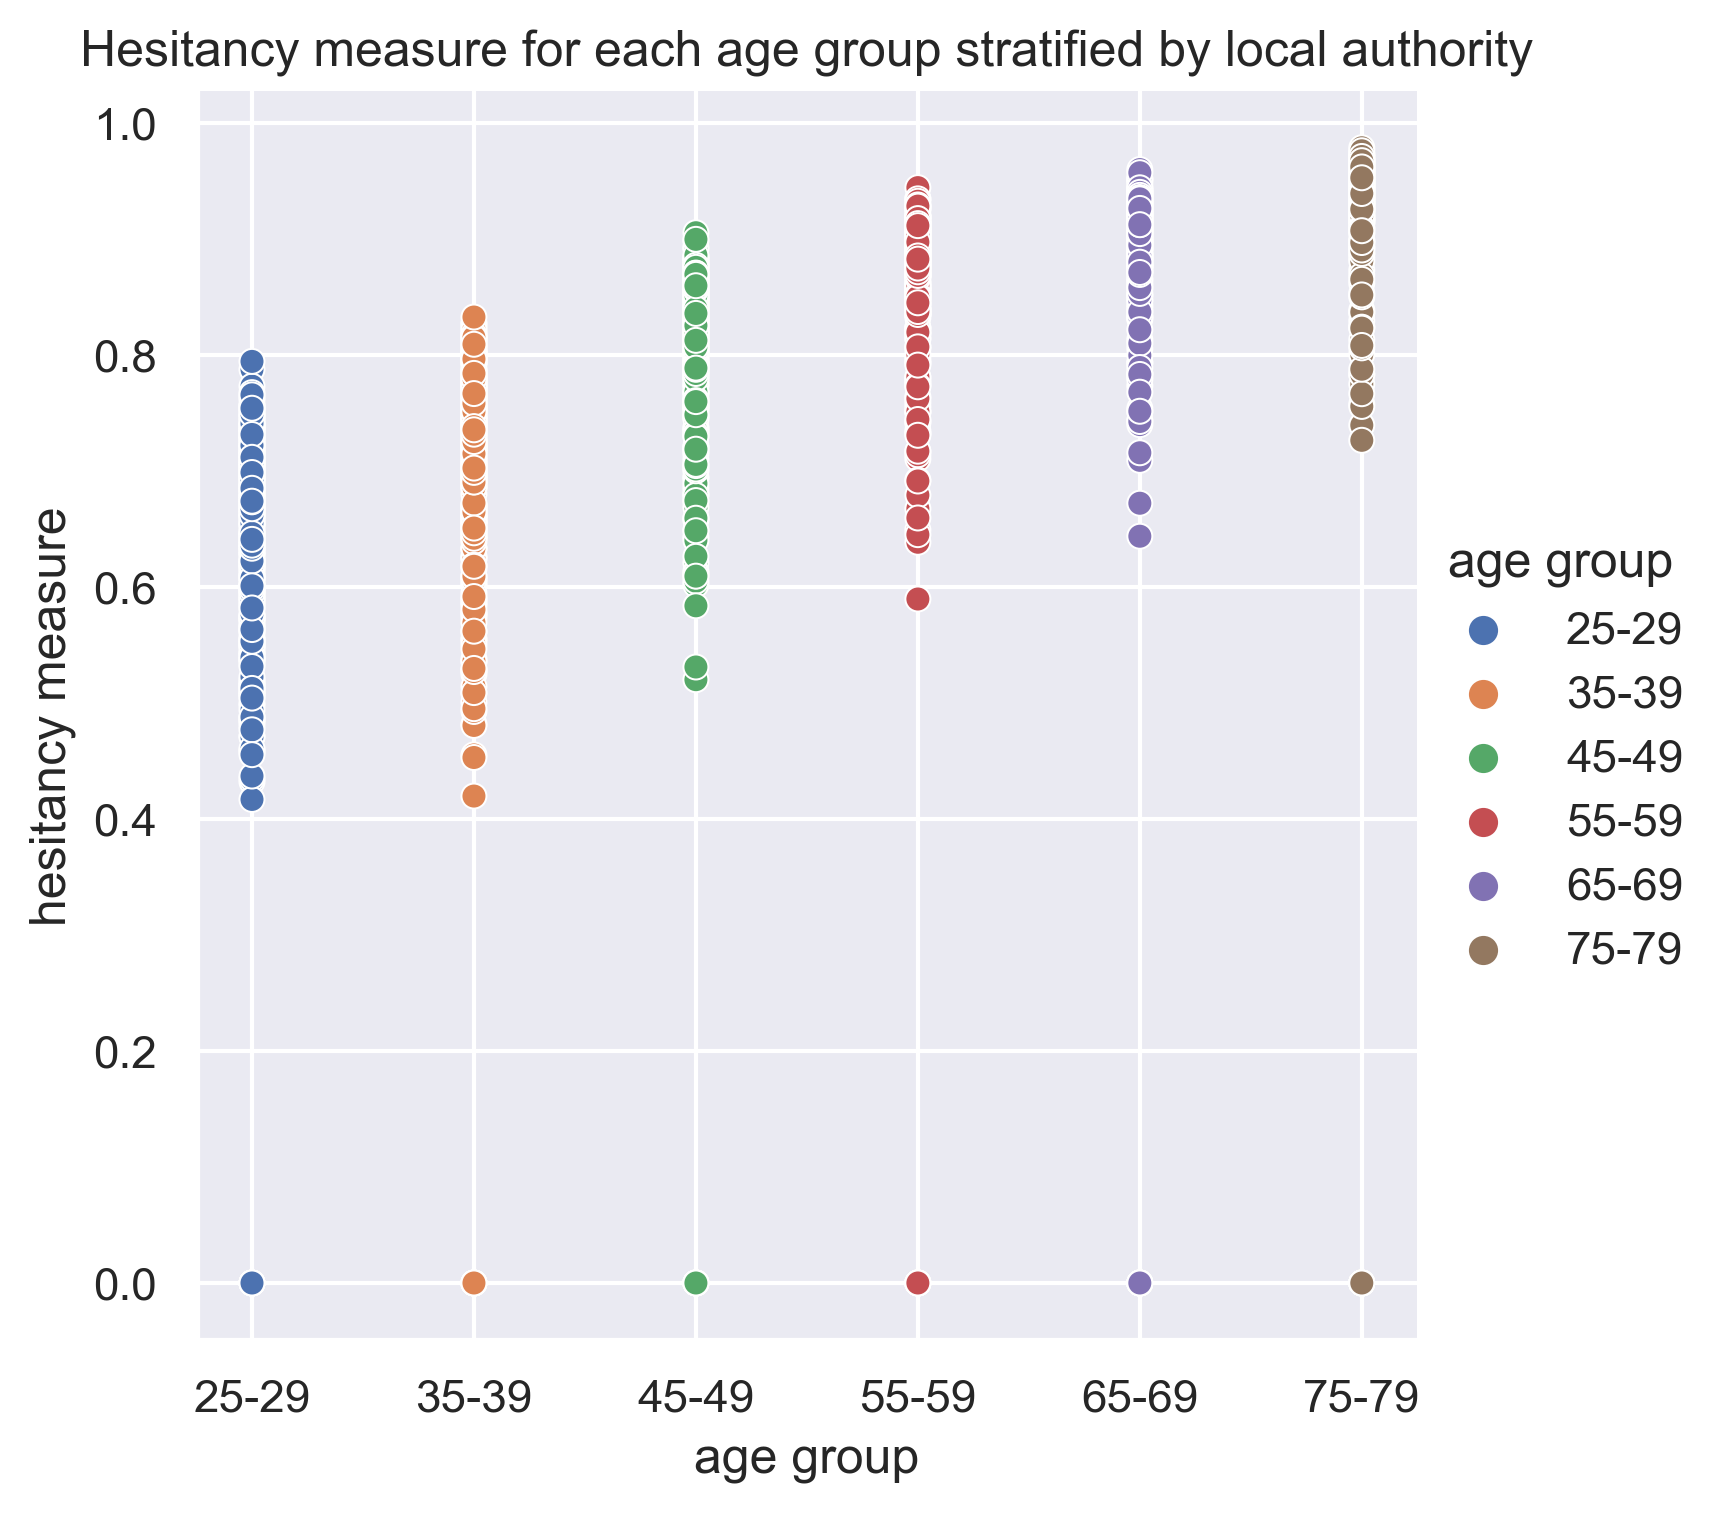

In [25]:
# plot coefficients
title = 'Hesitancy measure for each age group stratified by local authority'

# plot
sns.relplot(data=half_ltla_age_hesitancy_df, x='age group', y='hesitancy measure', hue='age group')

plt.title(title)
plt.savefig('./Desktop/MSc Project/Outputs/' + title + '.png')
plt.show()

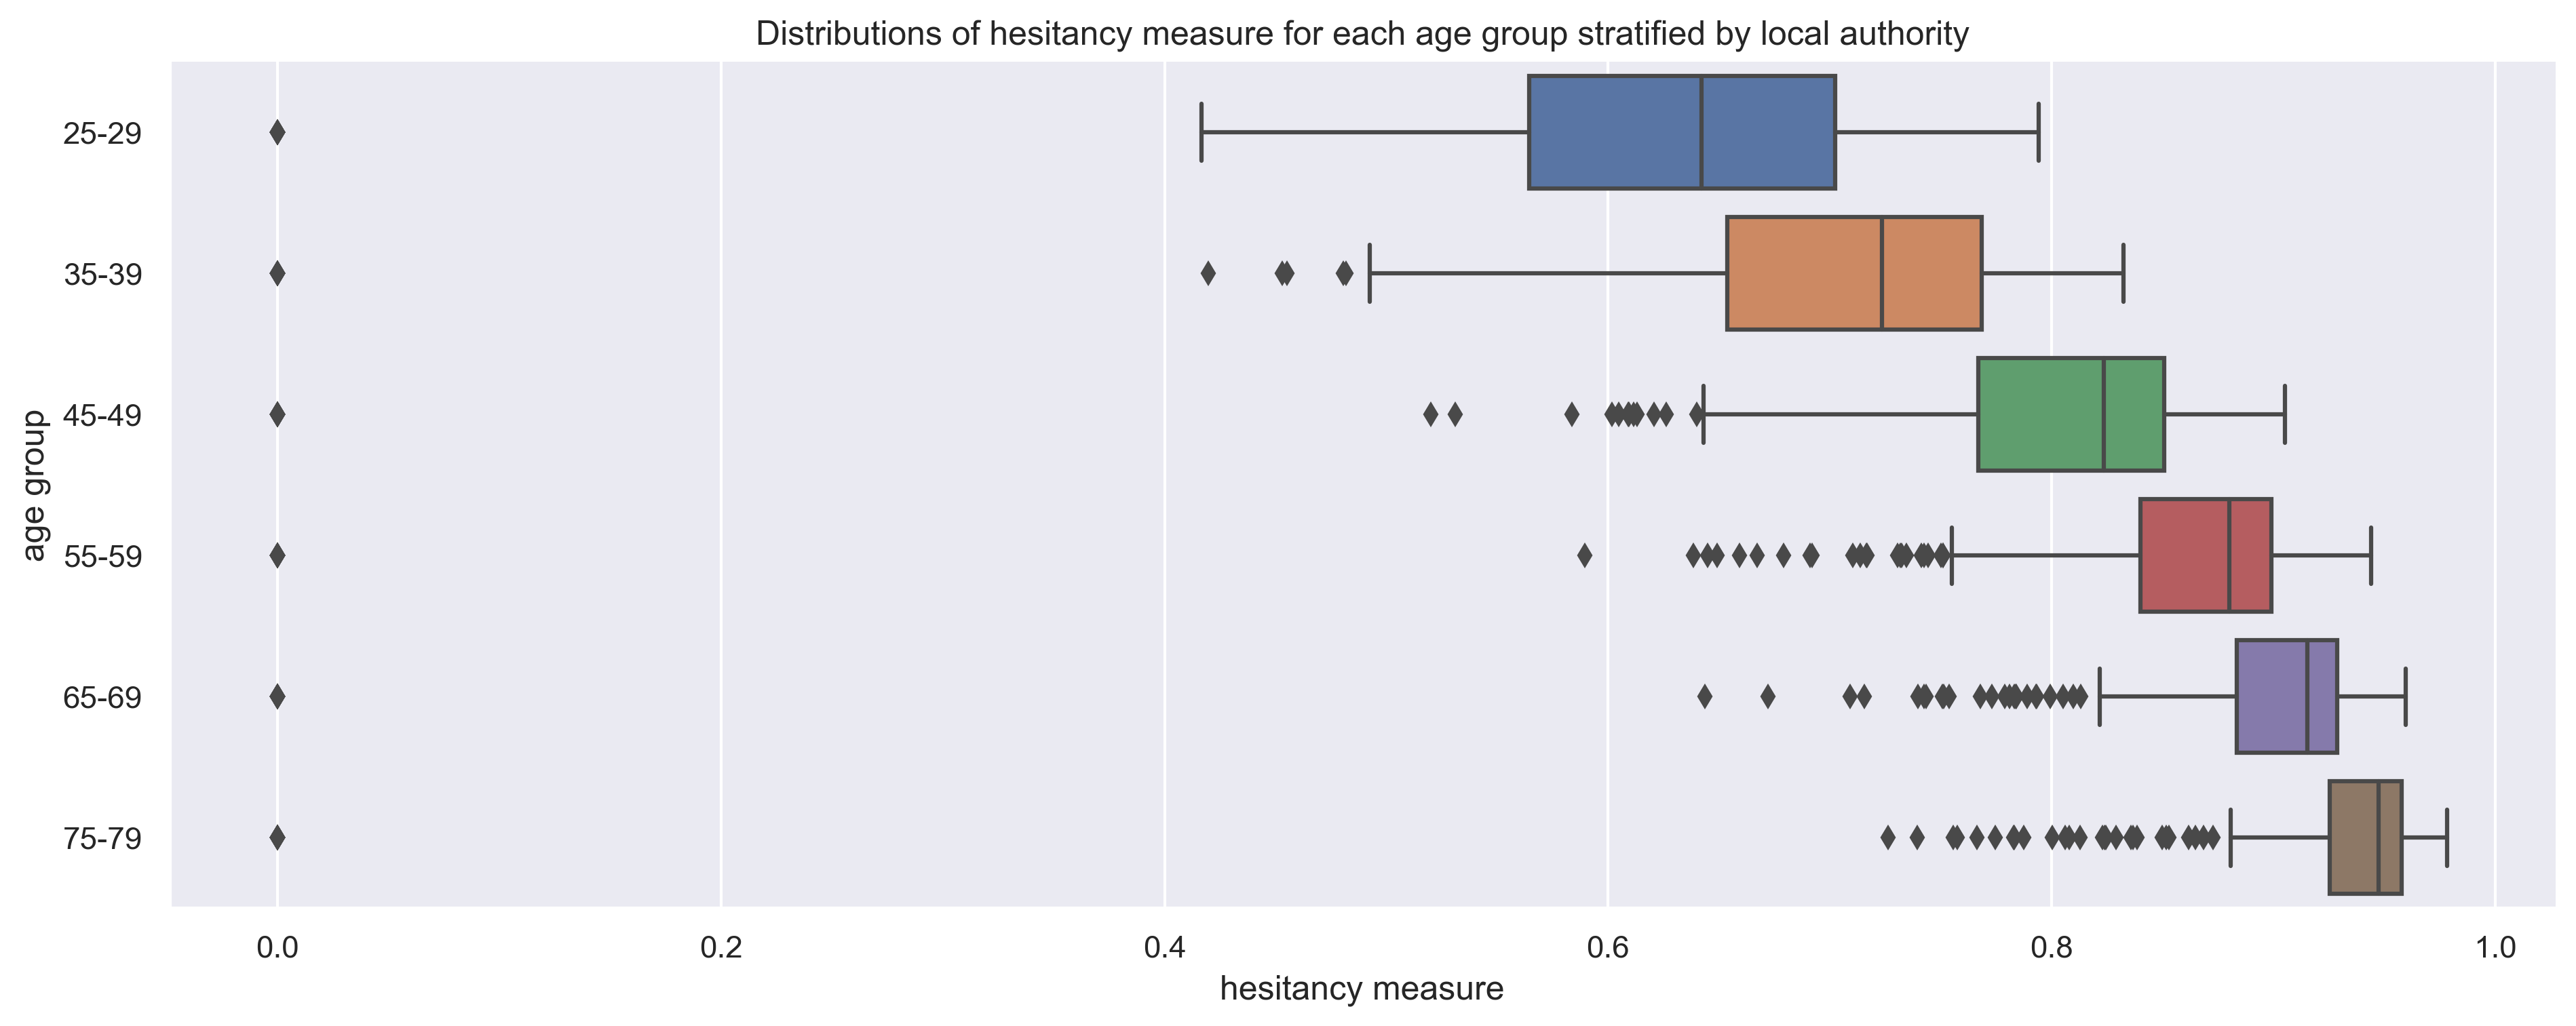

In [26]:
# plot coefficients
title = 'Distributions of hesitancy measure for each age group stratified by local authority'

# plot again but as boxplots
g = sns.catplot(y='age group', x='hesitancy measure', data=half_ltla_age_hesitancy_df, kind="box")
g.fig.set_size_inches(15,5)

plt.title(title)
plt.savefig('./Desktop/MSc Project/Outputs/' + title + '.png')
plt.show()

### Time by Vaccine Rate by LTLA

In [27]:
half_ltla_age_hesitancy_df.head(2)

,index,ltla name,age group,hesitancy measure
0,0,Adur,25-29,0.716255
2,2,Adur,35-39,0.770038


In [28]:
all_weekly_proportional_data[0].head(2)

,65-69,70-74,75-79,80+
ltla name,,,,
Adur,0.790907,0.941733,0.950318,0.949870
Allerdale,0.753844,0.951844,0.964493,0.966905


In [29]:
# collecting columns that are in both the vaccine and population dataframes, for every week

ltla_by_age_weekly_data = []

for i,df in enumerate(all_weekly_data5):
    ltla_by_age_weekly_data.append(
        all_weekly_data5[i][[col for col in all_weekly_data5[i].columns if col in all_weekly_pop_data4[i].columns]])

In [30]:
# check if the columns of ltla_by_age_weekly_data and all_weekly_pop_data4 are equally every week
for i,df in enumerate(ltla_by_age_weekly_data):
    N = 'all equal'
    if list(ltla_by_age_weekly_data[i].columns) != list(all_weekly_pop_data4[i].columns):
        N = 'not all equal'
print(N)

all equal


In [31]:
# what number, X, is in the column name 'under X'?

def under_what_number(df):
    
    under_list = list(df.columns.str.contains('under'))
    
    under_col_name = list(df[df.columns[under_list]].columns)
    
    num_ = ''

    for char in under_col_name[0]:
        if char.isdigit() == True:
            num_+=char
    return num_

In [32]:
ltla_weekly_pop_data = []

for df in all_weekly_pop_data:
    
    # set the index to the 'ltla name' column
    df1 = df.set_index(list(df.columns[df.columns.str.contains('ltla name')]))
    # remove duplicate columns that contains a '.'
    df2 = df1[df1.columns[~df1.columns.str.contains('\.')]]

    # find the number in the 'under' column
    under_number = under_what_number(df2)

    # get the under X and X+ columns only (to essentially find totally population estimate of area)
    list1 = list(df2.columns.str.contains('under ' + under_number))
    list2 = list(df2.columns.str.contains(under_number + '\+'))
    list3 = [a or b for a,b in zip(list1,list2)]
    
    # drop nans in index
    df3 = df2.loc[df2.index.dropna()]
    
    # put dataframe in a big list
    ltla_weekly_pop_data.append(df3[df3.columns[list3]])

In [33]:
aggregated_ltla_weekly_proportional_data = []

for i,df in enumerate(ltla_by_age_weekly_data):
    aggregated_ltla_weekly_proportional_data.append(
        ltla_by_age_weekly_data[i].sum(axis=1).divide(ltla_weekly_pop_data[i].sum(axis=1)))
    
    

In [34]:
# turn big list into big dataframe
df = pd.concat(aggregated_ltla_weekly_proportional_data, axis=1)
df = df.dropna()
df.columns = all_weekly_dates

In [35]:
# stack into one column and then expand multi index
test = df.stack().reset_index()
test = test.rename(columns = {'level_0':'ltla name','level_1': 'week ending',0: 'vaccine rate'})
test.head(2)

,ltla name,week ending,vaccine rate
0,Amber Valley,4th March 2021,0.211475
1,Amber Valley,11th March 2021,0.261352


In [36]:
# add a column of corresponding ordinal dates
test['date_ordinal'] = pd.to_datetime(test['week ending']).apply(lambda date: date.toordinal())

In [37]:
# add a column of corresponding datetimes
test['datetime'] = test['week ending'].apply(lambda date: pd.to_datetime(date))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
C:\Users\joshb\AppData\Local\Temp/ipykernel_3400/1723505159.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks_dates)


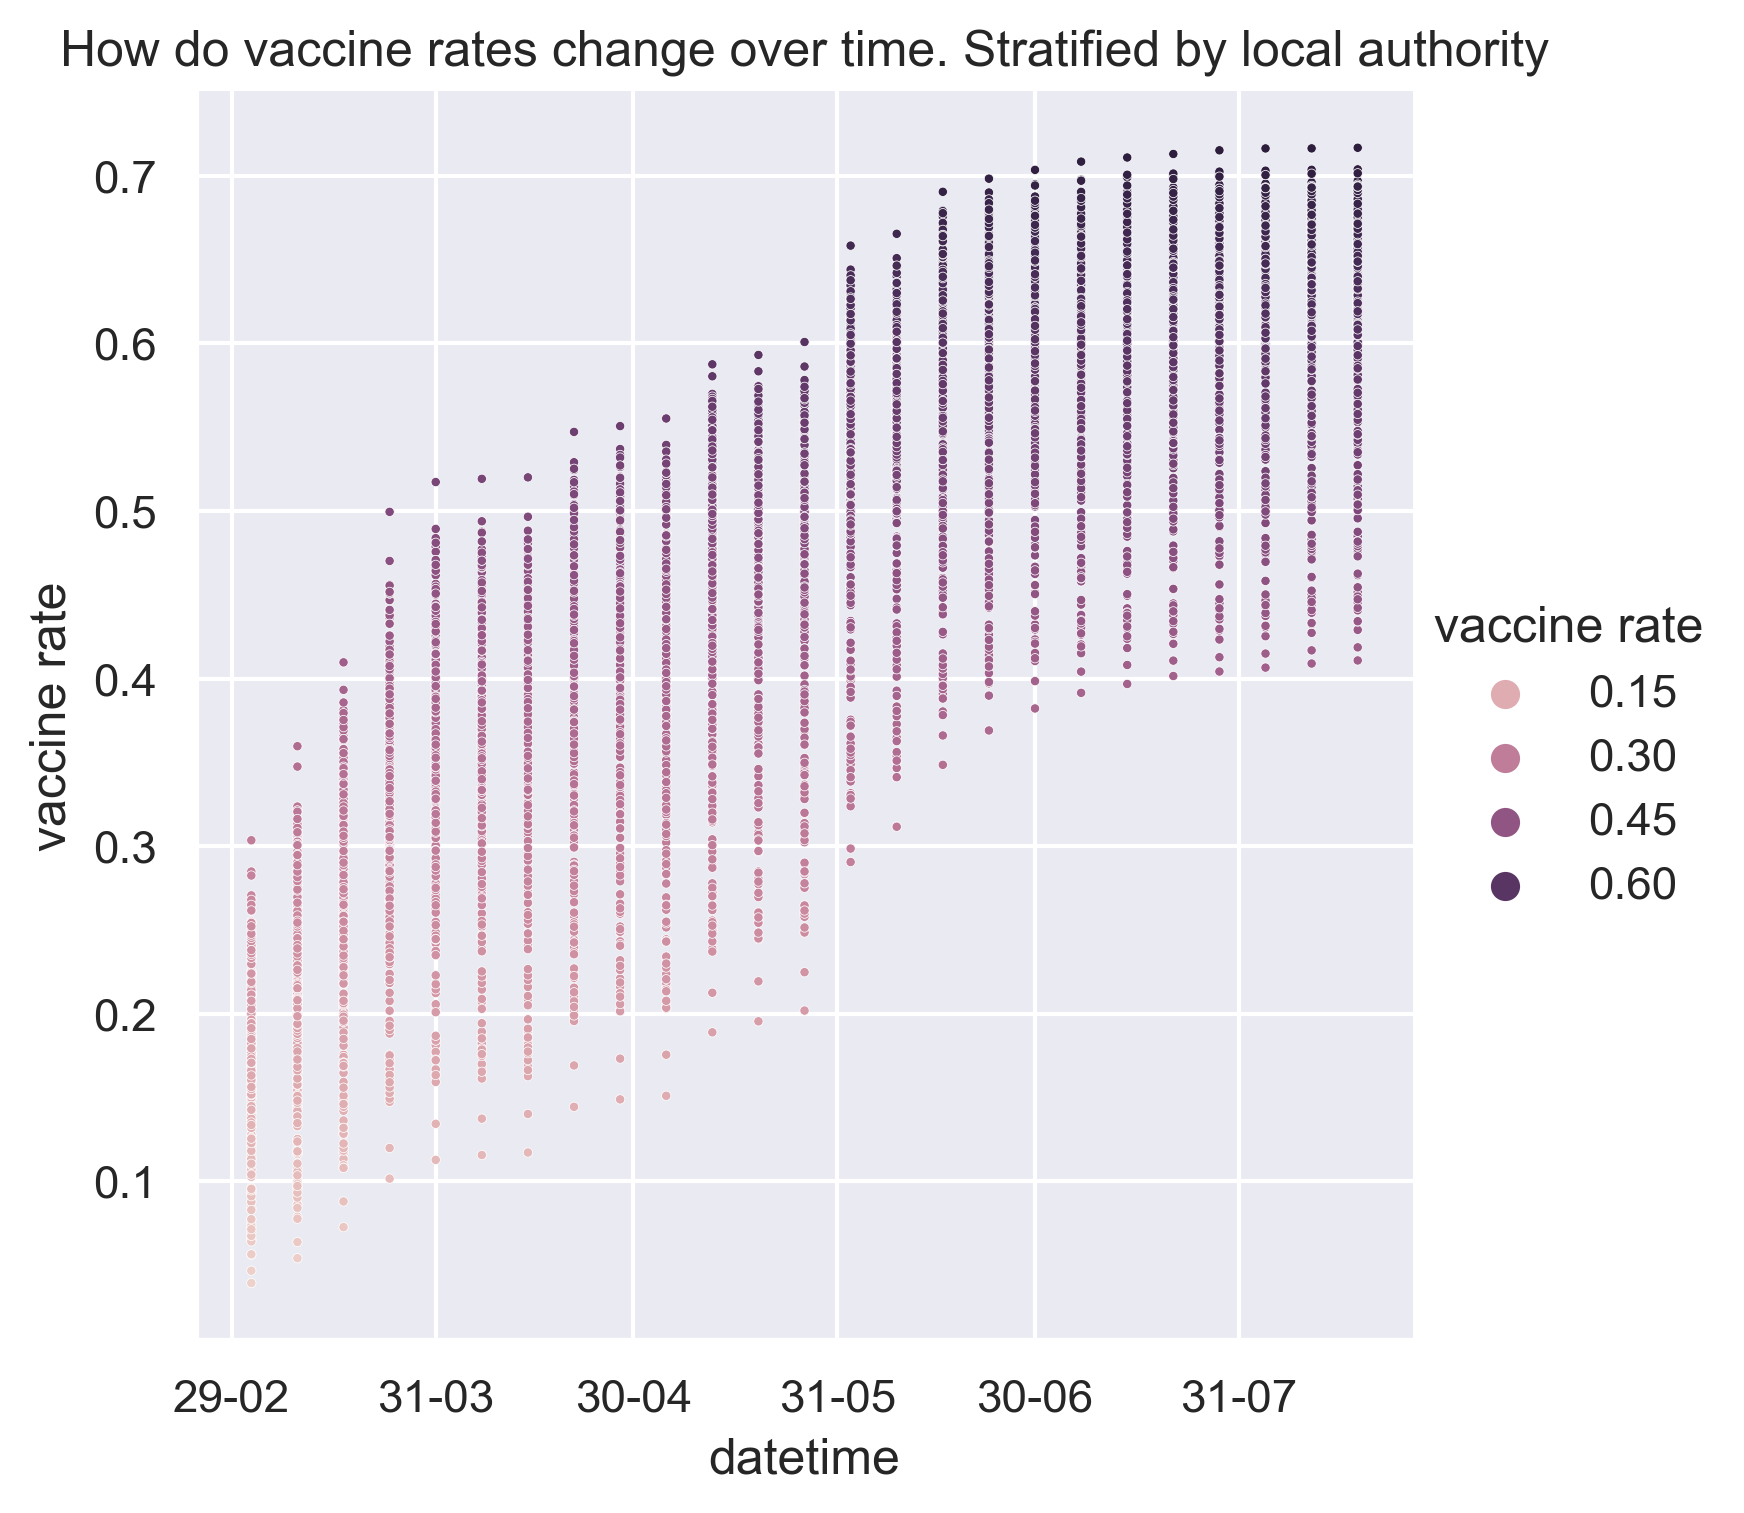

In [38]:
# plot coefficients
title = 'How do vaccine rates change over time. Stratified by local authority'

#plot
sns.relplot(data=test, x='datetime', y='vaccine rate',hue='vaccine rate', s=5, ax=g.ax)

ax = plt.gca()
xticks = ax.get_xticks()
xticks = xticks.astype(int)
xticks_dates = [datetime.datetime.fromordinal(x).strftime('%d-%m') for x in xticks]
ax.set_xticklabels(xticks_dates)

plt.title(title)
plt.savefig('./Desktop/MSc Project/Outputs/' + title + '1.png')
plt.show()

In [39]:
# calculate mean for each date

test['mean for date'] = [
    np.median([test['vaccine rate'][test['week ending'] == test['week ending'][i]]]) for i in range(0,len(test))
]

C:\Users\joshb\AppData\Local\Temp/ipykernel_3400/3545409080.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks_dates)
C:\Users\joshb\AppData\Local\Temp/ipykernel_3400/3545409080.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks_rates)


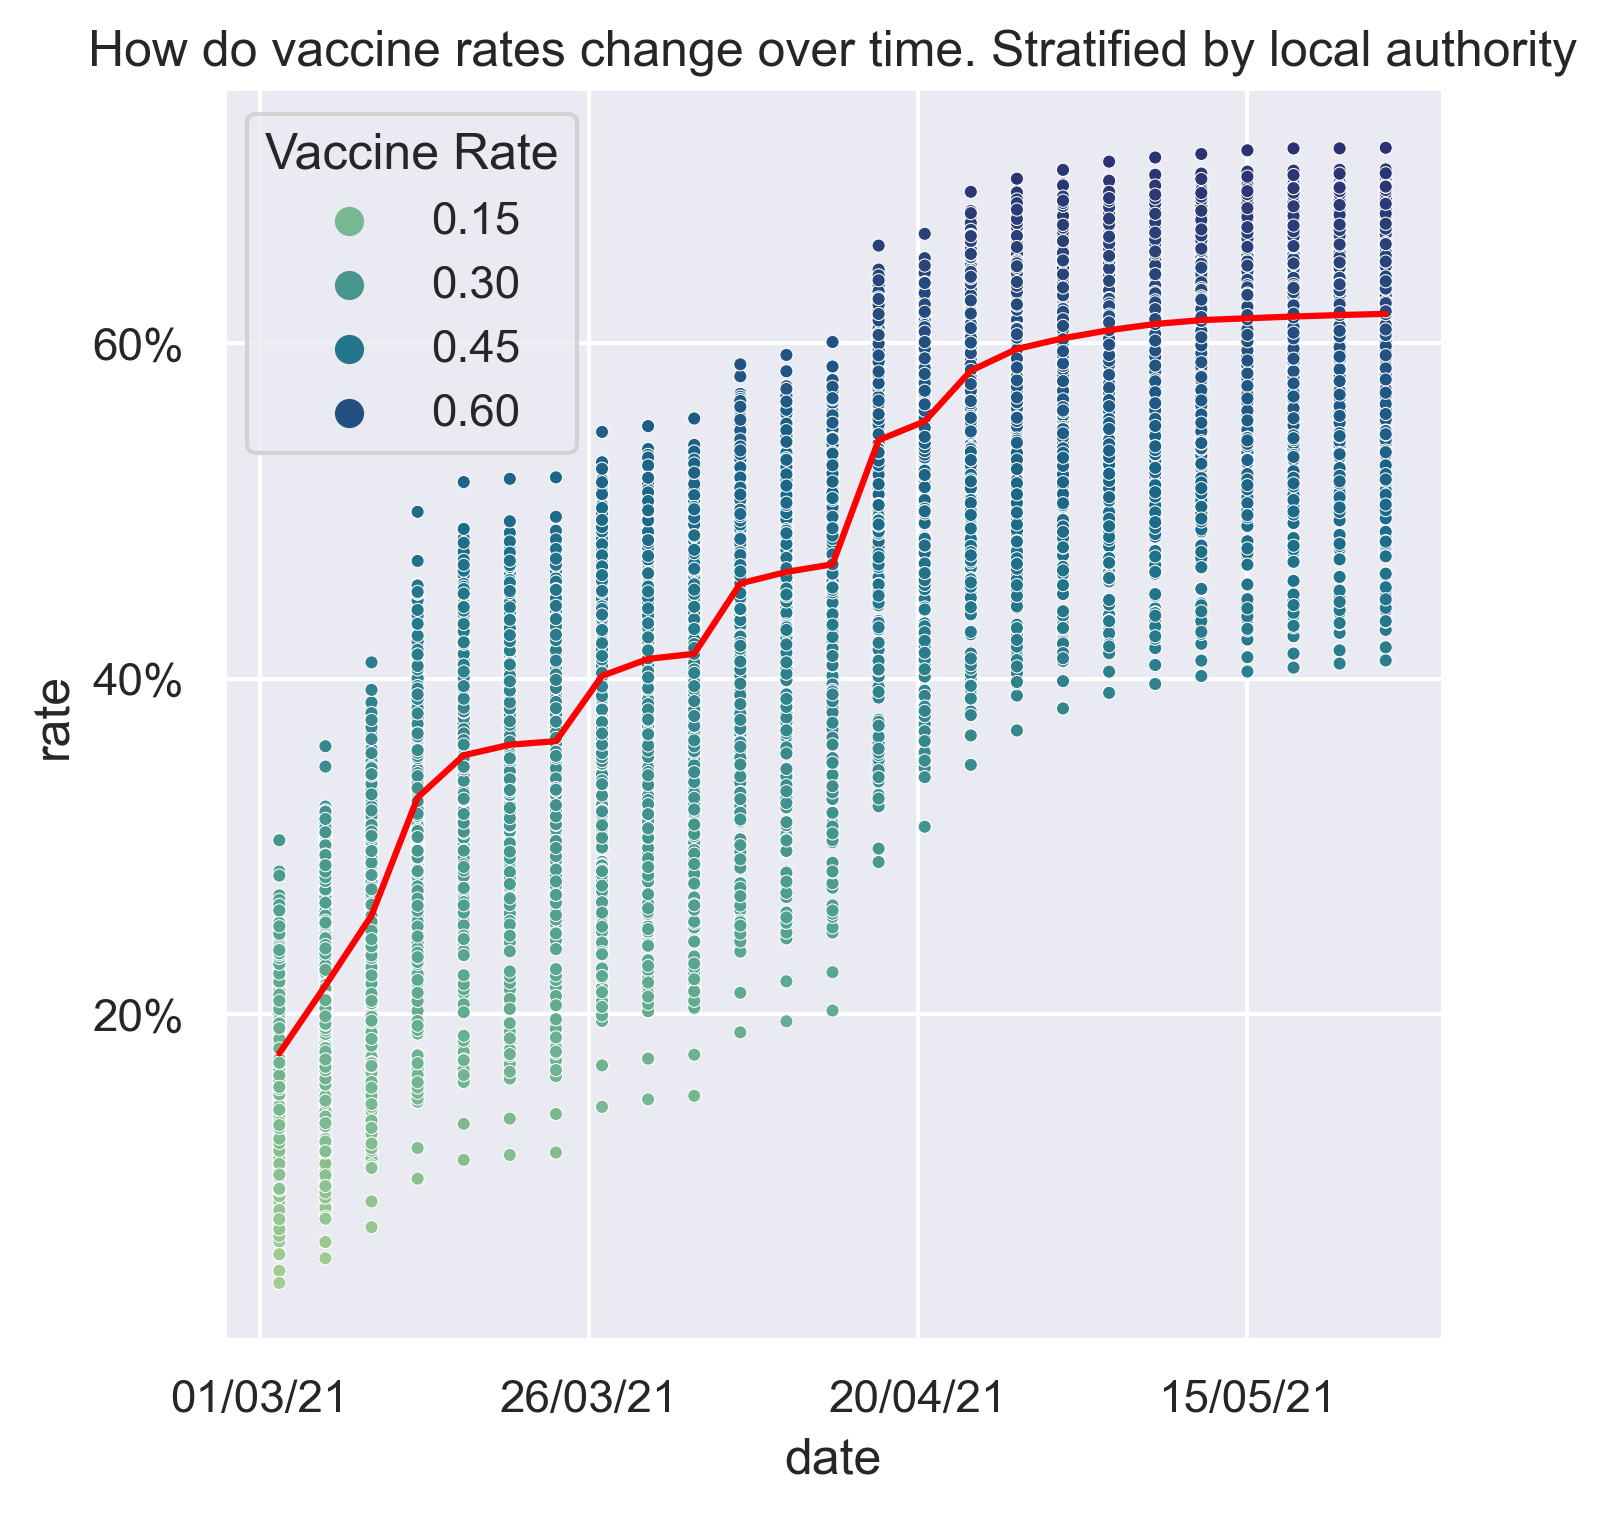

In [40]:
# plot again with linear regression line
title = 'How do vaccine rates change over time. Stratified by local authority'

g1 = sns.relplot(data=test, 
                 x='date_ordinal', 
                 y='vaccine rate', 
                 hue='vaccine rate', 
                 s=10,
                 palette=sns.color_palette("crest", as_cmap=True),
                )
#
#sns.regplot(data=test, 
#            x='date_ordinal', 
#            y='vaccine rate', 
#            scatter=False, 
#            color='red', 
#            scatter_kws={"s": 5}, 
#            line_kws={'linewidth':1}, 
#            label='foo'
#           )
#


g2 = sns.lineplot(data=test, 
                  x='date_ordinal', 
                  y='mean for date', 
                  color='red'
                 )

# x axis formatting
ax = plt.gca()
xticks = ax.get_xticks()
xticks = xticks.astype(int)
xticks_dates = [datetime.datetime.fromordinal(x).strftime('%d/%m/%y') for x in xticks]
ax.set_xticklabels(xticks_dates)
ax.set_xlabel('date')
ax.locator_params(nbins=4)


# y axis formatting
ax = plt.gca()
yticks = ax.get_yticks()
yticks_rates = ["{:.0%}".format(y) for y in yticks]
ax.set_yticklabels(yticks_rates)
ax.set_ylabel('rate')

# general formatting
plt.title(title)
g2.legend(title='Vaccine Rate')
g1._legend.remove()

plt.title(title)
plt.savefig('./Desktop/MSc Project/Outputs/' + title + '2.png')
plt.show()